### **To Count the number of images in each directories**

In [ ]:

# Define the directories for train, test, and validation
import os
train_dir = '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/train'
test_dir = '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/test'
val_dir = '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/val'

train_count = len(os.listdir(os.path.join(train_dir, 'label_0'))) + len(os.listdir(os.path.join(train_dir, 'label_1')))
test_count = len(os.listdir(os.path.join(test_dir, 'label_0'))) + len(os.listdir(os.path.join(test_dir, 'label_1')))
val_count = len(os.listdir(os.path.join(val_dir, 'label_0'))) + len(os.listdir(os.path.join(val_dir, 'label_1')))

total_count = train_count + test_count + val_count

print('Train Count:', train_count)
print('Test Count:', test_count)
print('Validation Count:', val_count)

print('\nTrain Percentile:', round(train_count/total_count*100, 2))
print('Test Percentile:', round(test_count/total_count*100, 2))
print('Validation Percentile:', round(val_count/total_count*100, 2))



Train Count: 340
Test Count: 63
Validation Count: 121

Train Percentile: 64.89
Test Percentile: 12.02
Validation Percentile: 23.09


# **DenseNet 121 : Transfer Learning**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Preparation
train_path= '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/train'
test_path=   '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/test'
validation_path='/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/Final_caliper_data/val'
img_height = 224
img_width = 224
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen= ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 340 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [2]:
model=tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
)

In [3]:
# freeze pre-trained layers
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [4]:
d1=tf.keras.layers.Dense(2,activation='softmax')(tf.keras.layers.GlobalMaxPooling2D()(model.output))
densenet=tf.keras.models.Model(inputs=model.input,outputs=d1)

In [5]:
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [6]:
densenet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#n_classes=3
n_steps = train_generator.samples // batch_size
n_val_steps = validation_generator.samples // batch_size
n_epochs = 50
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/crlcaliper-densenet_categorical.h5',
                                  save_best_only=True,
                                  monitor='val_acc',
                                  mode='max',
                                  verbose=2)

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history=densenet.fit(train_generator,validation_data=validation_generator,epochs=n_epochs, steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1], 
                            verbose=1)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.3742 - acc: 0.5185
Epoch 1: val_acc improved from -inf to 0.60714, saving model to /content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/crlcaliper-densenet_categorical.h5
21/21 [==============================] - 204s 9s/step - loss: 1.3742 - acc: 0.5185 - val_loss: 1.0825 - val_acc: 0.6071
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.9079 - acc: 0.6389
Epoch 2: val_acc did not improve from 0.60714
21/21 [==============================] - 8s 349ms/step - loss: 0.9079 - acc: 0.6389 - val_loss: 0.8579 - val_acc: 0.6071
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.7065 - acc: 0.6944
Epoch 3: val_acc improved from 0.60714 to 0.66071, saving model to /content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/crlcaliper-densenet_categorical.h5
21/21 [==============================] - 10s 482ms/step - loss: 0.7065 - acc: 0.6944 - val_loss: 0.6806 - val_acc: 0.66

In [11]:
# evaluate the model on the test set
#test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Sagital_Binary_classification/Sagital_Rotate/test', target_size=[img_height,img_width], batch_size=16, shuffle=False, class_mode='categorical')
test_loss, test_acc = densenet.evaluate(test_generator, verbose=1)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

4/4 [==============================] - 20s 7s/step - loss: 0.2689 - acc: 0.8889
Test Loss: 0.2689225673675537
Test Accuracy: 0.8888888955116272


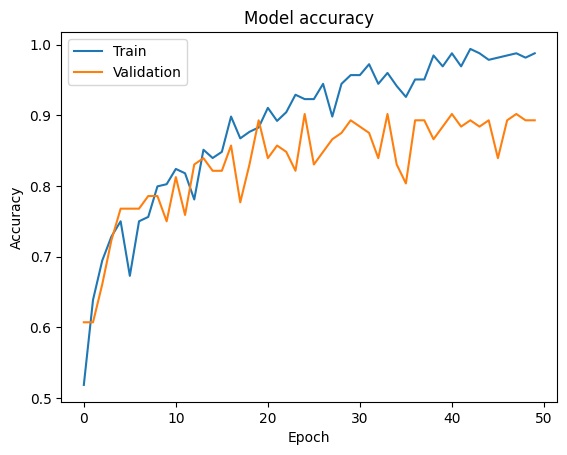

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **GradCam Visualization**

In [14]:
densenet.load_weights('/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/crlcaliper-densenet_categorical.h5')

In [24]:
import cv2
IMG_SIZE=224
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

@tf.function
def compute_gradcam_map(model, image, eps=1e-8):
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []
#     return model.get_layer(index=47).name
@tf.function
def generate_gradcam(img, label, global_model):
    fused_heatmap = compute_gradcam_map(global_model, img)
    return fused_heatmap
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)   
    return fused_heatmaps
def overlay_heatmap(image, heatmap, alpha=0.7,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

In [25]:
#train_dir='/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Sagital_Binary_classification/Sagital_Rotate/train'

In [26]:
img_height=224
img_width=224
#Generate a new generator with a smaller batch size to visualize the gradcams
new_test_generator = test_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=6,
    class_mode='categorical')


Found 340 images belonging to 2 classes.


In [39]:
images, y = new_test_generator.next()

In [40]:
tf.config.run_functions_eagerly(True)
gradcams = generate_gradcam_batch(images, densenet,0.5)

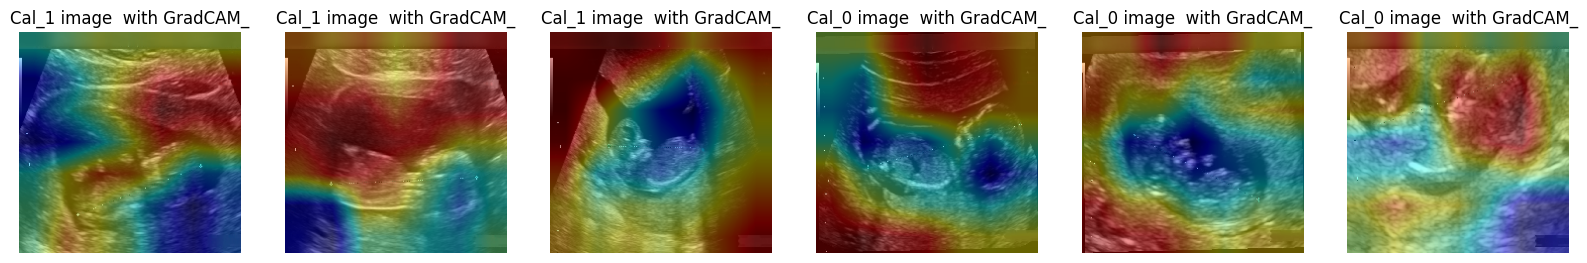

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
alpha=0.6
# Assuming gradcam is a list of GradCAM heatmaps for the images in train_generator
# images is a batch of images from train_generator
#images, y = new_test_generator.next()

# Overlay GradCAM heatmaps on images
overlayed_images = []
for i in range(len(images)):
    # Normalize the heatmap to have values between 0 and 1
    heatmap = gradcams[i]
    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #heatmap = (heatmap * 255.).astype('uint8')

    # Overlay the heatmap on the original image using alpha blending
    overlayed_image=cv2.addWeighted((images[i].squeeze() * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    #overlayed_image = cv2.addWeighted(images[i].astype(np.uint8), 0.3, heatmap.astype(np.uint8), 0.7, 0)
    overlayed_images.append(overlayed_image)

# Display the overlayed images with titles
fig, axs = plt.subplots(1, len(overlayed_images), figsize=(20, 5))
for i, overlayed_image in enumerate(overlayed_images):
  if np.argmax(y[i])==1:
      label= 'Cal_1'
  else:
      label='Cal_0'
  
  axs[i].imshow(overlayed_image)
  axs[i].set_title( label+ ' image '  + ' with GradCAM_')
  for a in axs:
    a.axis('off') 
plt.show()

## **Save Overlayed Gradcams**

In [42]:
import os
outputpath = '//content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/grad_densenet'
gradcams_dir = os.path.join(outputpath, 'gradcams')
os.makedirs(gradcams_dir, exist_ok=True)

for i, overlayed_image in enumerate(overlayed_images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(overlayed_image)
    ax.axis('off')
    img_path = os.path.join(gradcams_dir, f"{i+22}_{label}.jpg")
    plt.axis('tight')
    plt.savefig(img_path)
    plt.close(fig)


# **GradCam++**

In [7]:
densenet.load_weights('/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/CRL-Caliper/crlcaliper-densenet_categorical.h5')

In [15]:
from tensorflow.keras.models import Model

@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

@tf.function
def grad_cam_plus(model, img,
                  layer_name=get_last_layer_name(densenet), label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
       max_heat = 1e-10
    heatmap /= max_heat
    #heatmap=normalize(grad_cam_map)
    return heatmap
@tf.function
def generate_gradcamplus_batch(imgs, global_model):

    fused_heatmaps = []
    for image in imgs:
        heatmap = grad_cam_plus(global_model,image)
        fused_heatmaps.append(heatmap )

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)  
    return fused_heatmaps 

In [10]:
# Generate a new generator with a smaller batch size to visualize the gradcams
img_height=224
img_width=224
#Generate a new generator with a smaller batch size to visualize the gradcams
new_test_generator = test_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=6,
    class_mode='categorical')


Found 340 images belonging to 2 classes.


In [19]:
images, labels = new_test_generator.next()

In [20]:
import numpy as np
tf.config.run_functions_eagerly(True)
gradcamplus = generate_gradcamplus_batch(images, densenet)

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
alpha=0.5
# Assuming gradcam is a list of GradCAM heatmaps for the images in train_generator
# images is a batch of images from train_generator
#images, y = new_test_generator.next()

# Overlay GradCAM heatmaps on images
overlayed_images = []
for i in range(len(images)):
    # Normalize the heatmap to have values between 0 and 1
    heatmap = gradcamplus [i]
    #heatmap = heatmap - np.min(heatmap)     heatmap = heatmap / np.max(heatmap)     heatmap = np.uint8(255 * heatmap)     heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0])) heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #heatmap = (heatmap * 255.).astype('uint8')
    #images[i] = images[i] / 255.0
    heatmap = heatmap - np.min(heatmap) 
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #overlayed_image=heatmap * 0.5 + images[i]
    #overlayed_image = np.clip(overlayed_image, 0, 255).astype("uint8")
    #overlayed_image = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)
    #overlayed_image = Image.fromarray(overlayed_image)
    # Overlay the heatmap on the original image using alpha blending
    overlayed_image=cv2.addWeighted((images[i].squeeze() * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    #overlayed_image = cv2.addWeighted(images[i].astype(np.uint8), 0.3, heatmap.astype(np.uint8), 0.7, 0)
    overlayed_images.append( overlayed_image)

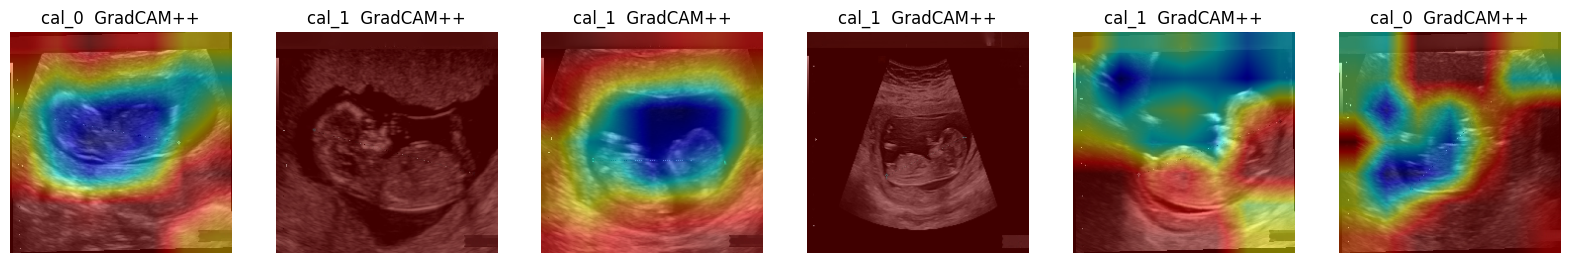

In [22]:
# Display the overlayed images with titles
fig, axs = plt.subplots(1, len(overlayed_images), figsize=(20, 5))
for i, overlayed_image in enumerate(overlayed_images):
  if np.argmax(labels[i])==1:
      label= 'cal_1'
  else:
      label='cal_0'
  
  axs[i].imshow(overlayed_image)
  axs[i].set_title( label + '  GradCAM++')
  for a in axs:
    a.axis('off') 
plt.show()